<a href="https://colab.research.google.com/github/AI4Finance-LLC/Elegant-FinRL/blob/main/StockTrading_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Trading Demo in Elegant-FinRL**






# **Part 1: Problem Formulation**
Formally, we model stock trading as a Markov Decision Process (MDP), and formulate the trading objective as maximization of expected return:



*   **State s = [b, p, h]**: a vector that includes the remaining balance b, stock prices p, and stock shares h. p and h are vectors with D dimension, where D denotes the number of stocks. 
*   **Action a**: a vector of actions over D stocks. The allowed actions on each stock include selling, buying, or holding, which result in decreasing, increasing, or no change of the stock shares in h, respectively.
*   **Reward r(s, a, s’)**: The asset value change of taking action a at state s and arriving at new state s’.
*   **Policy π(s)**: The trading strategy at state s, which is a probability distribution of actions at state s.
*   **Q-function Q(s, a)**: the expected return (reward) of taking action a at state s following policy π.
*   **State-transition**: After taking the actions a, the number of shares h is modified, as shown in Fig 3, and the new portfolio is the summation of the balance and the total value of the stocks.

# **Part 2: Stock Trading Environment Design**

**State Space and Action Space**


*   **State Space**: We use a 181-dimensional vector consists of seven parts of information to represent the state space of multiple stocks trading environment: [b, p, h, M, R, C, X], where b is the balance, p is the stock prices, h is the number of shares, M is the Moving Average Convergence Divergence (MACD), R is the Relative Strength Index (RSI), C is the Commodity Channel Index (CCI), and X is the Average Directional Index (ADX).
*   **Action Space**: As a recap, we have three types of actions: selling, buying, and holding for a single stock. We use the negative value for selling, positive value for buying, and zero for holding. In this case, the action space is defined as {-k, …, -1, 0, 1, …, k}, where k is the maximum share to buy or sell in each transaction.


**Easy-to-customize Features**


*   **initial_capital**: the initial capital that the user wants to invest.
*   **tickers**: the stocks that the user wants to trade with.
*   **initial_stocks**: the initial amount of each stock and the default could be zero.
*   **buy_cost_pct, sell_cost_pct**: the transaction fee of each buying or selling transaction.
*   **max_stock**: the user is able to define the maximum number of stocks that are allowed to trade per transaction. Users can also set the maximum percentage of capitals to invest in each stock.
*   **tech_indicator_list**: the list of financial indicators that are taken into account, which is used to define a state.
*   **start_date, start_eval_date, end_eval_date**: the training and backtesting time intervals. Thee time dates (or timestamps) are used, once the training period is specified, the rest is backtesting.


# **Part 3: Install Elegant-FinRL and related packages**

In [1]:
!pip install git+https://github.com/AI4Finance-LLC/Elegant-FinRL.git

  Cloning https://github.com/AI4Finance-LLC/Elegant-FinRL.git to /tmp/pip-req-build-woutv9uq
  Running command git clone -q https://github.com/AI4Finance-LLC/Elegant-FinRL.git /tmp/pip-req-build-woutv9uq
     |████████████████████████████████| 5.5MB 8.0MB/s 
  Created wheel for elegant-finrl: filename=elegant_finrl-0.3.1-cp37-none-any.whl size=30499 sha256=de6300c9e1cb83c3c78c96523a732578bce81ee0f8df6fa9ee7455e924a68813
  Stored in directory: /tmp/pip-ephem-wheel-cache-vx3mqudt/wheels/dd/db/5a/f6532ee3a6251f178544bf879a20491a9c14f20db47c74df69
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=d487b536ad4eb3f72658512f7b29038216c65d74b2b1030043f395a429ae3d63
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built elegant-finrl yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# **Part 4: Import Packages**


*   **Elegant-FinRL**
*   **yfinance**: yfinance aims to solve this problem by offering a reliable, threaded, and Pythonic way to download historical market data from Yahoo! finance.
*   **StockDataFrame**: stockstats inherits and extends pandas.DataFrame to support Stock Statistics and Stock Indicators.



In [3]:
from elegant_finrl.run import *
from elegant_finrl.agent import AgentPPO, AgentDDPG
from elegant_finrl.env import StockTradingEnv
import yfinance as yf
from stockstats import StockDataFrame as Sdf

# **Part 5: Specify Agent and Environment**

*   **args.agent**: firstly chooses one DRL algorithm to use from agent.py. In this application, we prefer to choose DDPG and PPO agent.
*   **args.env**: creates the environment, and the user can either customize own environment or preprocess environments from OpenAI Gym and PyBullet Gym from env.py. In this application, we create the self-designed stock trading environment.


> Before finishing initialization of **args**, please see Arguments() in run.py for more details about adjustable hyper-parameters.




In [4]:
# Agent
args = Arguments(if_on_policy=True)
args.agent = AgentPPO() # AgentSAC(), AgentTD3(), AgentDDPG()
args.agent.if_use_gae = True
args.agent.lambda_entropy = 0.04

# Environment
tickers = [
  'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'ALXN', 'AMAT', 'AMD', 'AMGN',
  'AMZN', 'ASML', 'ATVI', 'BIIB', 'BKNG', 'BMRN', 'CDNS', 'CERN', 'CHKP', 'CMCSA',
  'COST', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'DLTR', 'EA', 'EBAY', 'FAST',
  'FISV', 'GILD', 'HAS', 'HSIC', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG',
  'JBHT', 'KLAC', 'LRCX', 'MAR', 'MCHP', 'MDLZ', 'MNST', 'MSFT', 'MU', 'MXIM',
  'NLOK', 'NTAP', 'NTES', 'NVDA', 'ORLY', 'PAYX', 'PCAR', 'PEP', 'QCOM', 'REGN',
  'ROST', 'SBUX', 'SIRI', 'SNPS', 'SWKS', 'TTWO', 'TXN', 'VRSN', 'VRTX', 'WBA',
  'WDC', 'WLTW', 'XEL', 'XLNX']  # finrl.config.NAS_74_TICKER

tech_indicator_list = [
  'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
  'close_30_sma', 'close_60_sma']  # finrl.config.TECHNICAL_INDICATORS_LIST

gamma = 0.99
max_stock = 1e2
initial_capital = 1e6
initial_stocks = np.zeros(len(tickers), dtype=np.float32)
buy_cost_pct = 1e-3
sell_cost_pct = 1e-3
start_date = '2008-03-19'
start_eval_date = '2016-01-01'
end_eval_date = '2021-01-01'

args.env = StockTradingEnv('./', gamma, max_stock, initial_capital, buy_cost_pct, 
                           sell_cost_pct, start_date, start_eval_date, 
                           end_eval_date, tickers, tech_indicator_list, 
                           initial_stocks, if_eval=False)
args.env_eval = StockTradingEnv('./', gamma, max_stock, initial_capital, buy_cost_pct, 
                           sell_cost_pct, start_date, start_eval_date, 
                           end_eval_date, tickers, tech_indicator_list, 
                           initial_stocks, if_eval=True)

args.env.target_reward = 3
args.env_eval.target_reward = 3

# Hyperparameters
args.gamma = gamma
args.break_step = int(2e5)
args.net_dim = 2 ** 9
args.max_step = args.env.max_step
args.max_memo = args.max_step * 4
args.batch_size = 2 ** 10
args.repeat_times = 2 ** 3
args.eval_gap = 2 ** 4
args.eval_times1 = 2 ** 3
args.eval_times2 = 2 ** 5
args.if_allow_break = False
args.rollout_num = 2 # the number of rollout workers (larger is not always faster)

| FeatureEngineer: start processing data (2 minutes)
| YahooDownloader: start downloading data (1 minute)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complet

# **Part 6: Train and Evaluate the Agent**

> The training and evaluating processes are all finished inside function **train_and_evaluate_mp()**, and the only parameter for it is **args**. It includes the fundamental objects in DRL:

*   agent,
*   environment.

> And it also includes the parameters for training-control:

*   batch_size,
*   target_step,
*   reward_scale,
*   gamma, etc.

> The parameters for evaluation-control:

*   break_step,
*   random_seed, etc.






In [5]:
train_and_evaluate_mp(args) # the training process will terminate once it reaches the target reward.

| multiprocessing, act_workers: 2
| multiprocessing, None:
| GPU id: 0, cwd: ./AgentPPO/StockTradingEnv-v1_0
| Remove history
ID      Step      MaxR |    avgR      stdR       objA      objC
0   0.00e+00      3.10 |
ID      Step   TargetR |    avgR      stdR   UsedTime  ########
0   7.84e+03      3.00 |    3.10      0.05        126  ########
0   2.35e+04      3.10 |    2.84      0.04      -0.50      1.94
0   2.35e+04      3.29 |
0   3.14e+04      3.68 |
0   4.71e+04      3.68 |    3.64      0.04      -0.50      1.45
0   4.71e+04      3.87 |
0   7.06e+04      3.87 |    3.32      0.03      -0.50      1.02
0   1.02e+05      3.87 |    3.84      0.02      -0.50      1.58
0   1.02e+05      4.11 |
0   1.10e+05      4.27 |
0   1.26e+05      4.27 |    3.67      0.03      -0.50      1.48
0   1.65e+05      4.27 |    3.67      0.06      -0.50      0.93
0   2.04e+05      4.27 |    3.80      0.05      -0.50      0.75
| print_state_norm(): state_dim: (5883, 741) is too large to print its norm. 
| Save

Understanding the above results::
*   **Step**: the total training steps.
*  **MaxR**: the maximum reward.
*   **avgR**: the average of the rewards.
*   **stdR**: the standard deviation of the rewards.
*   **objA**: the objective function value of Actor Network (Policy Network).
*   **objC**: the objective function value (Q-value)  of Critic Network (Value Network).

# **Part 7: Backtest and Draw the Graph**

| GPU id: 0, cwd: ./AgentPPO/StockTradingEnv-v1_0
Loaded act: ./AgentPPO/StockTradingEnv-v1_0


[0.9995955649202543,
 0.9975446945901687,
 0.9935693924378951,
 0.9915617982886925,
 0.9913834403196347,
 0.9928634375965022,
 0.9867860271102115,
 0.9909559327370578,
 0.9863285019955724,
 0.985785946898047,
 0.9871788668424668,
 0.9875730968750025,
 0.9925369006027934,
 0.9894437961500596,
 0.9912232496484528,
 0.9870172692952998,
 0.9867888843294875,
 0.9940082401878245,
 0.9949120745028646,
 0.9871291589347889,
 0.9884568769771255,
 0.9882611948075709,
 0.9771771560899478,
 0.9694342242476699,
 0.9680577166874633,
 0.9689376861574259,
 0.9674589795306585,
 0.9745281539271055,
 0.9824887047279829,
 0.9898611787820273,
 0.9854021086799497,
 0.9897072422878241,
 0.9958319614556523,
 0.9903959264126875,
 0.9941479140408692,
 0.9988510072245363,
 0.9989240046617178,
 0.9961703292622108,
 1.0117223135842253,
 1.0112255698324566,
 1.009290952102534,
 1.0092525085272963,
 1.0092851477215736,
 1.0013185888338594,
 1.0017594753250263,
 1.0012819450836423,
 1.0100866567661184,
 1.011398244705

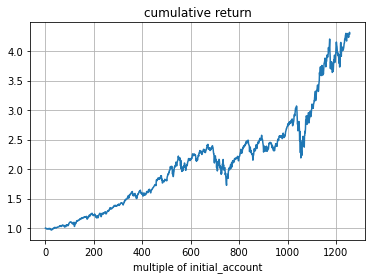

In [8]:
args = Arguments(if_on_policy=True)
args.agent = AgentPPO()
args.env = StockTradingEnv(cwd='./', if_eval=True)
args.if_remove = False
args.cwd = './AgentPPO/StockTradingEnv-v1_0'
args.init_before_training()

args.env.draw_cumulative_return(args, torch)